# MyoPS 2020 Challenge

Ideas: 
 - load data via torchio
 - include meaningful augmentations
 - retrain base network (U-Net, resnet34)
 - use fastai2
 - use all labels (incl. LV, MY, RV)
 - use cross validation on training set to estimate performance

## Save transformed images from torchio to files and load these via fastai2

Unfortunately I could not get the direct loading of images to work - so this workaround seems simple enough.
Although it has some drawbacks (e.g. no on the fly calculations of different transforms every time) and advantages (e.g. fixed transform results for reproducibility, scaling can be moved to fastai so no need to scale the z direction).

In [1]:
import torchio
from torchio.transforms import RescaleIntensity, RandomMotion, RandomGhosting, RandomSpike, RandomBiasField, RandomBlur, RandomNoise, RandomSwap, ZNormalization
from torchvision.transforms import Compose, ToPILImage
from torch.utils.data import DataLoader
from fastai2.vision.all import *
from fastai2.vision.models import resnet34
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696



In [2]:
torch.cuda.set_device(0)

In [3]:
files = glob('../data/train25/myops_training_*_C0.nii.gz')

In [4]:
subjects = [torchio.Subject(
    bssfp = torchio.Image(f, torchio.INTENSITY),
    LGE = torchio.Image(f.replace("C0","DE"), torchio.INTENSITY),
    T2 = torchio.Image(f.replace("C0","T2"), torchio.INTENSITY),
    label = torchio.Image(f.replace("train25","train25_myops_gd").replace("C0","gd"), torchio.LABEL),
    name = f.split("_")[2]
) for f in files]

In [5]:
transforms = [
    RescaleIntensity((0, 1)),  # applied only to torchio.INTENSITY images
    # CenterCropOrPad((256,256,5)),
    # RandomAffine(),  # applied to all images in the sample
    # RandomGhosting(),
]

# Transforms can be composed as in torchvision.transforms
transform = Compose(transforms)

# ImagesDataset is a subclass of torch.data.utils.Dataset
subjects_dataset = torchio.ImagesDataset(subjects, transform=transform)

In [6]:
plain_loader = DataLoader(subjects_dataset, batch_size=1, num_workers=1)

In [7]:
def get_x_y(element):
    x = torch.cat((element['bssfp']['data'][0],element['LGE']['data'][0],element['T2']['data'][0]),dim=0).permute(3,0,1,2)
    y = element['label']['data'][0,0,:,:,:]
    # The provided gold standard labels include: 
    # left ventricular (LV) blood pool (labelled 500),
    # right ventricular blood pool (600), 
    # LV normal myocardium (200),
    # LV myocardial edema (1220),
    # LV myocardial scars (2221), 
    # though the evaluation of the test data will be focused on the myocardial pathology segmentation, i.e., scars and edema. 
    y[y==500] = 1
    y[y==200] = 2
    y[y==600] = 3
    y[y==1220] = 4
    y[y==2221] = 5
    y=y.permute(2,0,1)
    return x,y

In [3]:
pil = ToPILImage()
path = "../data/png"

In [9]:
def generate_images_fromLoader(loader, name):
    for element in tqdm(loader):
        pid = element['bssfp']['stem'][0].split("_")[2]
        x,y = get_x_y(element)
        for i,(a,b) in enumerate(zip(x,y)):
            x_img = pil(a)
            x_img.save(f"{path}/images/{pid}-{name}-{i}.png")
            pil(a[0]).save(f"{path}/bssfp/{pid}-{name}-{i}.png")
            pil(a[1]).save(f"{path}/LGE/{pid}-{name}-{i}.png")
            pil(a[2]).save(f"{path}/T2/{pid}-{name}-{i}.png")
            y_img = Image.fromarray(b.int().numpy(), 'I')
            y_img.save(f"{path}/masks/{pid}-{name}-{i}.png")

In [54]:
generate_images_fromLoader(plain_loader, "orig")

In [71]:
iteration = 1
dataset = DataLoader(torchio.ImagesDataset(subjects, transform=Compose([RescaleIntensity((0,1)),RandomGhosting(),RescaleIntensity((0,1))])), batch_size=1)
generate_images_fromLoader(dataset, f"ghost_{iteration}")
dataset = DataLoader(torchio.ImagesDataset(subjects, transform=Compose([RescaleIntensity((0,1)),RandomMotion(),RescaleIntensity((0,1))])), batch_size=1)
generate_images_fromLoader(dataset, f"motion_{iteration}")
dataset = DataLoader(torchio.ImagesDataset(subjects, transform=Compose([RescaleIntensity((0,1)),RandomSpike(),RescaleIntensity((0,1))])), batch_size=1)
generate_images_fromLoader(dataset, f"spike_{iteration}")
dataset = DataLoader(torchio.ImagesDataset(subjects, transform=Compose([RescaleIntensity((0,1)),RandomBiasField(),RescaleIntensity((0,1))])), batch_size=1)
generate_images_fromLoader(dataset, f"biasField_{iteration}")
dataset = DataLoader(torchio.ImagesDataset(subjects, transform=Compose([RescaleIntensity((0,1)),RandomBlur(),RescaleIntensity((0,1))])), batch_size=1)
generate_images_fromLoader(dataset, f"blur_{iteration}")
dataset = DataLoader(torchio.ImagesDataset(subjects, transform=Compose([RescaleIntensity((0,1)),ZNormalization(),RandomNoise(),RescaleIntensity((0,1))])), batch_size=1)
generate_images_fromLoader(dataset, f"noise_{iteration}")

/home/ankenbrand/miniconda3/envs/fastai/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


### fastai U-Net on these static images

In [4]:
def acc_seg(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

In [5]:
dice0inv = partial(multi_dice, class_id=0, inverse=True)
dice1 = partial(multi_dice, class_id=1)
dice2 = partial(multi_dice, class_id=2)
dice3 = partial(multi_dice, class_id=3)
dice4 = partial(multi_dice, class_id=4)
dice5 = partial(multi_dice, class_id=5)
dice0inv.__name__ = 'diceComb'
dice1.__name__ = 'diceLV'
dice2.__name__ = 'diceMY'
dice3.__name__ = 'diceRV'
dice4.__name__ = 'diceEd'
dice5.__name__ = 'diceSc'


In [6]:
myopsData = DataBlock(blocks=(ImageBlock, MaskBlock(codes = ['bg','lv','my','rv','ed','sc'])),
    get_items=get_image_files,
    splitter=FuncSplitter(lambda o: int(o.name.split("-")[0]) < 106),
    get_y=lambda o: str(o).replace("images","masks"),
    item_tfms=Resize(256),
    batch_tfms=aug_transforms(max_rotate=90))
myopsDls = myopsData.dataloaders(f'{path}/images',num_workers=8,batch_size=4)

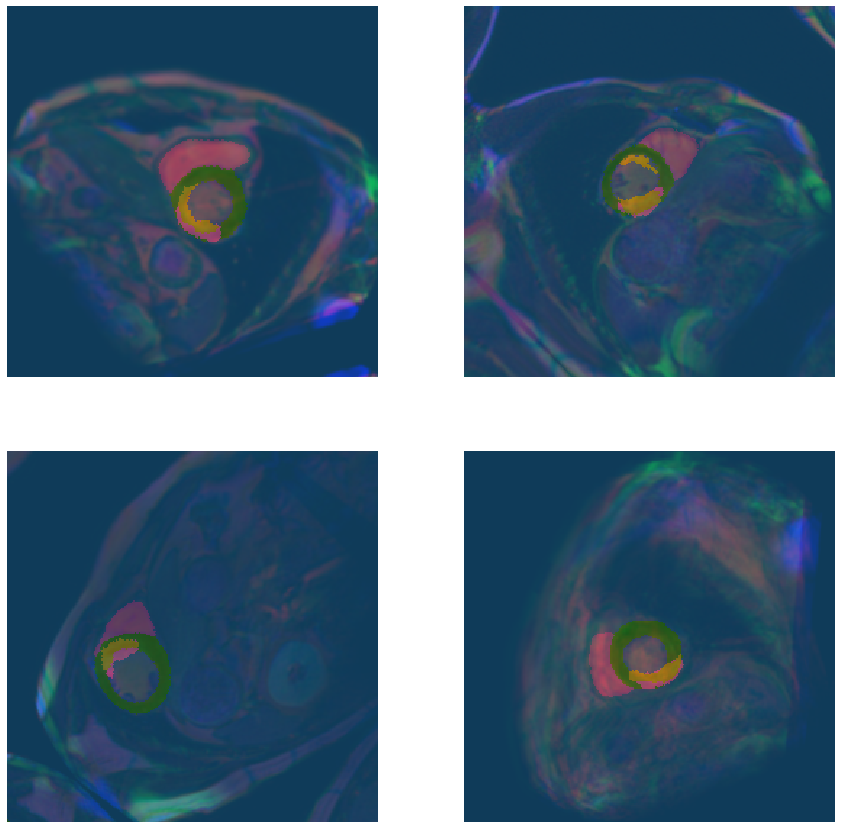

In [7]:
myopsDls.show_batch(figsize=(15,15))

In [8]:
learn = unet_learner(myopsDls, resnet34, metrics=[acc_seg,dice0inv,dice1,dice2,dice3,dice4,dice5])

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=4.365158383734524e-05)

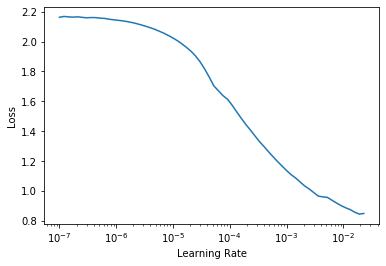

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(20,lr_max=1e-3)

epoch,train_loss,valid_loss,acc_seg,multi_dice,multi_dice,multi_dice,multi_dice,multi_dice,multi_dice,time
0,0.116957,0.064399,0.979183,0.823016,0.660934,0.461095,0.644854,0.100000,0.251249,01:35
1,0.058038,0.068225,0.980370,0.783712,0.687783,0.426021,0.641598,0.095595,0.203602,01:13
2,0.047646,0.052264,0.983839,0.880016,0.802647,0.624789,0.695294,0.100223,0.214754,01:12
3,0.048534,0.041416,0.986127,0.907076,0.840036,0.649507,0.803352,0.097640,0.247375,01:12
4,0.037509,0.045403,0.986218,0.885476,0.842158,0.648431,0.752949,0.100028,0.279343,01:11
5,0.048003,0.044197,0.986829,0.908997,0.838667,0.643024,0.795529,0.100115,0.232116,01:12
6,0.036829,0.037481,0.986791,0.905819,0.855289,0.670929,0.779218,0.108501,0.252469,01:11
7,0.033630,0.043656,0.987061,0.899700,0.860569,0.658033,0.795498,0.100417,0.244823,01:11
8,0.031664,0.040092,0.986752,0.899223,0.864624,0.660360,0.771580,0.093665,0.309956,01:11
9,0.029999,0.052802,0.986707,0.907768,0.862604,0.658375,0.773072,0.093671,0.226317,01:11


SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=1.3182567499825382e-06)

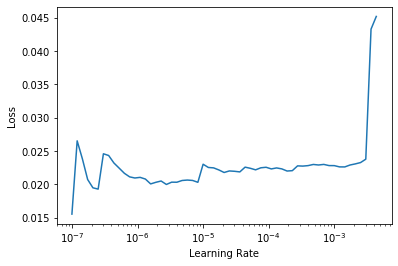

In [11]:
learn.unfreeze()
learn.lr_find()

In [12]:
learn.fit_one_cycle(20,lr_max=1e-4)

epoch,train_loss,valid_loss,acc_seg,multi_dice,multi_dice,multi_dice,multi_dice,multi_dice,multi_dice,time
0,0.023112,0.038691,0.987843,0.912364,0.877547,0.680340,0.776508,0.131205,0.353342,01:18
1,0.022025,0.036464,0.988052,0.917857,0.873836,0.683624,0.804162,0.123226,0.337183,01:17
2,0.022338,0.035482,0.988250,0.920559,0.879536,0.681906,0.820322,0.118828,0.369988,01:17
3,0.020888,0.033997,0.988446,0.926059,0.871144,0.687257,0.839612,0.152323,0.368731,01:17
4,0.023154,0.041130,0.987151,0.893972,0.852723,0.647029,0.773234,0.118997,0.347321,01:17
5,0.020935,0.042274,0.987571,0.902228,0.861716,0.663741,0.787131,0.123494,0.341491,01:17
6,0.021303,0.037937,0.987597,0.911685,0.869395,0.672590,0.767236,0.118081,0.328470,01:17
7,0.021031,0.039777,0.988123,0.916105,0.868975,0.678312,0.809976,0.113109,0.382448,01:17
8,0.021206,0.035494,0.988499,0.927502,0.870914,0.688544,0.847543,0.128101,0.352114,01:17
9,0.020423,0.039315,0.987733,0.910787,0.870611,0.689560,0.792127,0.132534,0.365364,01:17


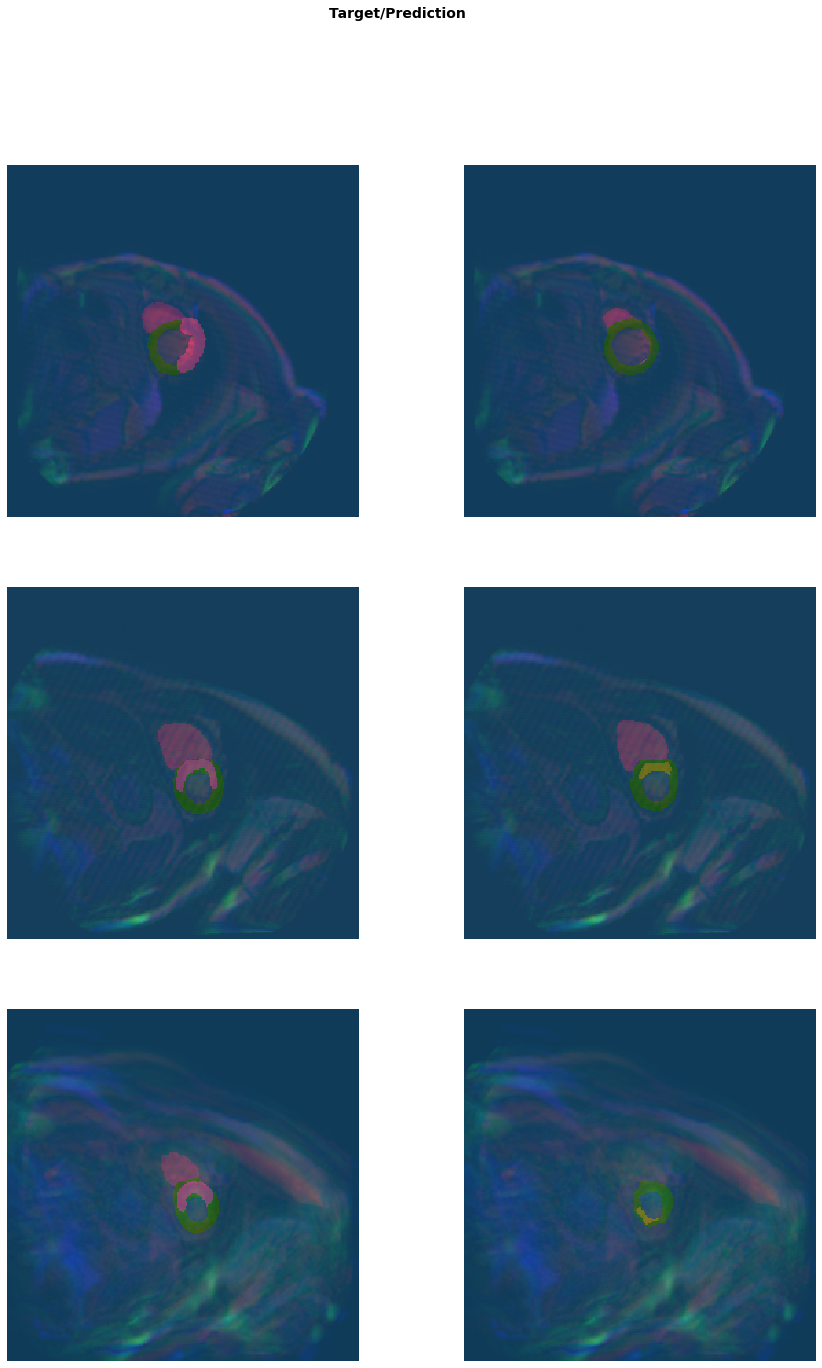

In [13]:
learn.show_results(figsize=(15,22))

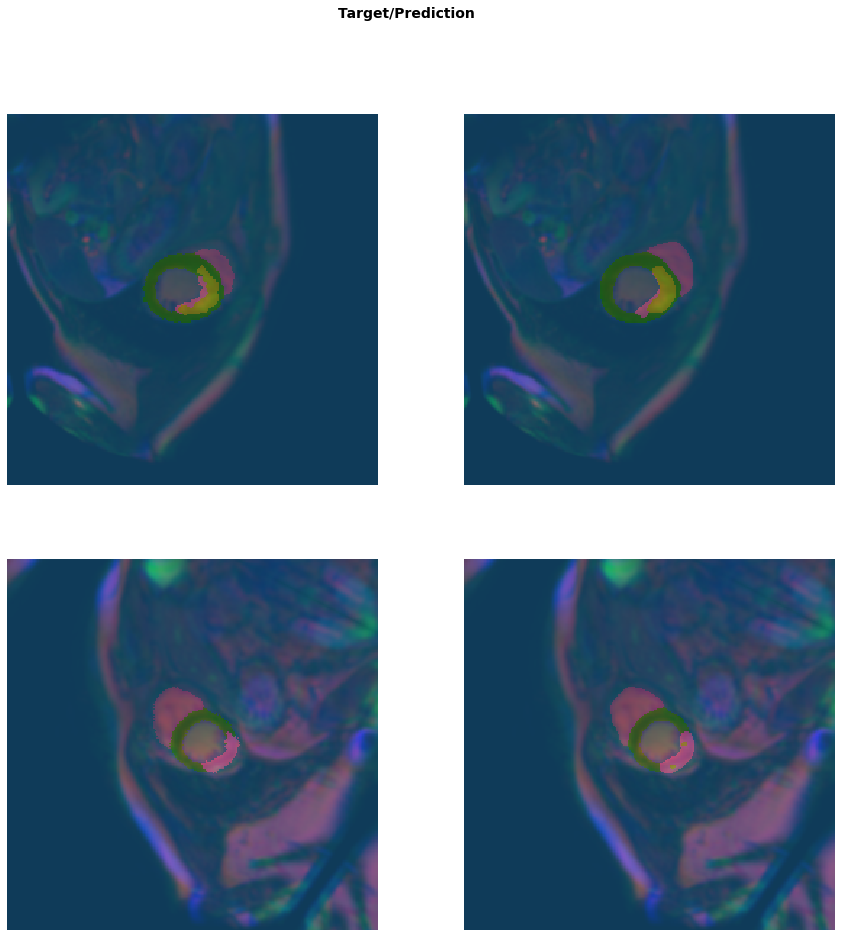

In [14]:
learn.show_results(ds_idx=0, figsize=(15,15))